# Imports and config

In [112]:
%matplotlib inline

from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
from matplotlib import pyplot as plt
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import os
import json

pd.options.display.float_format = lambda x: '%.2f' % x
plt.rcParams['figure.figsize'] = [10.0, 8.0]

# Setup

We download and build project dependencies. Do note that [git-lfs](https://git-lfs.com/) is required to clone the repos containing the models. The outputs of build scripts and such can be quite verbose, if scrolling does not enable automatically, in Spyder Notebook, right click the output pane and select "Enable scrolling for Outpus" or left click the blank space to the left of said output pane.

In [ ]:
# llama.cpp
! git clone https://github.com/ggerganov/llama.cpp.git
! cd llama.cpp && make

In [ ]:
# MS COCO dataset
! mkdir coco
! mkdir coco/images
! cd coco && curl -O http://images.cocodataset.org/annotations/annotations_trainval2014.zip
! cd coco && unzip -j annotations_trainval2014.zip annotations/captions_val2014.json
! rm coco/annotations_trainval2014.zip

In [ ]:
# LLaVA 1.5 7B
! git lfs clone https://huggingface.co/liuhaotian/llava-v1.5-7b
! git lfs clone https://huggingface.co/openai/clip-vit-large-patch14-336
! cd llama.cpp && python ./examples/llava/llava_surgery.py -m ../llava-v1.5-7b
! cd llama.cpp && python ./examples/llava/convert_image_encoder_to_gguf.py -m ../clip-vit-large-patch14-336 --llava-projector ../llava-v1.5-7b/llava.projector --output-dir ../llava-v1.5-7b
! cd llama.cpp && python ./examples/convert_legacy_llama.py ../llava-v1.5-7b --skip-unknown

In [ ]:
# LLaVa 1.6 7B
! git lfs clone https://huggingface.co/liuhaotian/llava-v1.6-vicuna-7b
! cd llama.cpp && python ./examples/llava/llava_surgery_v2.py -C -m ../llava-v1.6-vicuna-7b/
! mkdir llava-v1.6-vicuna-7b/vit
! cp llava-v1.6-vicuna-7b/llava.clip llava-v1.6-vicuna-7b/vit/pytorch_model.bin
! cp llava-v1.6-vicuna-7b/llava.projector llava-v1.6-vicuna-7b/vit/
! curl -s -q https://huggingface.co/cmp-nct/llava-1.6-gguf/raw/main/config_vit.json -o llava-v1.6-vicuna-7b/vit/config.json
! cd llama.cpp && python ./examples/llava/convert_image_encoder_to_gguf.py -m ../llava-v1.6-vicuna-7b/vit --llava-projector ../llava-v1.6-vicuna-7b/vit/llava.projector --output-dir ../llava-v1.6-vicuna-7b/vit --clip-model-is-vision
! cd llama.cpp && python ./examples/convert_legacy_llama.py ../llava-v1.6-vicuna-7b/ --skip-unknown

# Experiments

Next, different models at different quantization models and methods are evaluated. Do note that CLIP image encoder quantization is not supported by llama.cpp, hence only quantizations of the language model are considered.

In [91]:
def experiment(model, mmproj, seed=0, n_images=20, temp=0.1, prompt='"Suggest a short caption for this image."'):
    # ========================================================
    # Set up validation dataset
    # ========================================================
    coco = COCO('coco/captions_val2014.json')
    rng = np.random.default_rng(seed=seed)
    ids = rng.choice(coco.getImgIds(), size=n_images)
    imgs = coco.loadImgs(ids=ids)
    anns = coco.loadAnns(coco.getAnnIds(imgIds=ids))
    
    # ========================================================
    # Run and time individual image prompts
    # ========================================================
    data = []
    for img in imgs:
        path = 'coco/images/' + img['file_name']
        if not os.path.isfile(path):
            ! curl {img['coco_url']} > {path}
        t = timer()
        result = ! llama.cpp/llama-llava-cli -m {model} --mmproj {mmproj} --image {path} --temp {temp} -s {seed} -p {prompt}
        t = timer() - t
        caption = result[-7].strip()
        data += [{'image_id': img['id'], 'caption': caption, 'time': t}]
        print(img['file_name'] + ' | ' + caption)

    # ========================================================
    # Evaluate responses
    # ========================================================
    with open('coco/results.json', 'w') as f:
        json.dump(data, f, indent=4)
    cocoRes = coco.loadRes('coco/results.json')
    cocoEval = COCOEvalCap(coco, cocoRes)
    # sorted(...) mitigates inconsistent behavior of individual metrics
    cocoEval.params['image_id'] = sorted(cocoRes.getImgIds())
    cocoEval.evaluate()
    
    # ========================================================
    # Structure results
    # ========================================================
    df = pd.DataFrame(cocoEval.evalImgs).set_index('image_id')
    # 'f' here stands for f-score, other options include 'pr'(ecision), 're'(call), 'tp', 'fp', 'fn'
    df['SPICE All'] = [i['All']['f'] for i in df['SPICE']]
    df['SPICE Obj'] = [i['Object']['f'] for i in df['SPICE']]
    df['SPICE Rel'] = [i['Relation']['f'] for i in df['SPICE']]
    df = df.drop('SPICE', axis=1)
    df = df.join(pd.DataFrame(data).set_index('image_id'))
    return df

In [72]:
experiment_results = []

### LLaVA v1.5 7b, F16:

In [ ]:
print(f'MODEL SIZE: {os.path.getsize("llava-v1.5-7b/llava-v1.5-7B-F16.gguf") / 1024**3:.2f}G')
df = experiment(
    model='llava-v1.5-7b/llava-v1.5-7B-F16.gguf',
    mmproj='llava-v1.5-7b/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the Variable Explorer (burger menu -> open console)
df['model'] = 'llava-v1.5-7B-F16'
df = df.set_index('model', append=True)
experiment_results.append(df)

### LLaVA v1.5 7b, Q5_K:

In [ ]:
! llama.cpp/llama-quantize llava-v1.5-7b/llava-v1.5-7B-F16.gguf llava-v1.5-7b/llava-v1.5-7B-Q5_K.gguf Q5_K
print(f'MODEL SIZE: {os.path.getsize("llava-v1.5-7b/llava-v1.5-7B-Q5_K.gguf") / 1024**3:.2f}G')
df = experiment(
    model='llava-v1.5-7b/llava-v1.5-7B-Q5_K.gguf',
    mmproj='llava-v1.5-7b/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the variable viewer
df['model'] = 'llava-v1.5-7B-Q5_K'
df = df.set_index('model', append=True)
experiment_results.append(df)
! rm llava-v1.5-7b/llava-v1.5-7B-Q5_K.gguf

### LLaVA v1.5 7b, Q2_K:

In [ ]:
! llama.cpp/llama-quantize llava-v1.5-7b/llava-v1.5-7B-F16.gguf llava-v1.5-7b/llava-v1.5-7B-Q2_K.gguf Q2_K
print(f'MODEL SIZE: {os.path.getsize("llava-v1.5-7b/llava-v1.5-7B-Q2_K.gguf") / 1024**3:.2f}G')
df = experiment(
    model='llava-v1.5-7b/llava-v1.5-7B-Q2_K.gguf',
    mmproj='llava-v1.5-7b/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the variable viewer
df['model'] = 'llava-v1.5-7B-Q2_K'
df = df.set_index('model', append=True)
experiment_results.append(df)
! rm llava-v1.5-7b/llava-v1.5-7B-Q2_K.gguf

### LLaVA v1.6 7b, F16:

In [ ]:
! llama.cpp/llama-quantize llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-F32.gguf llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-F16.gguf F16
print(f'MODEL SIZE: {os.path.getsize("llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-F16.gguf") / 1024**3:.2f}G')
df = experiment(
    model='llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-F16.gguf',
    mmproj='llava-v1.6-vicuna-7b/vit/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the Variable Explorer (burger menu -> open console)
df['model'] = 'llava-v1.6-7B-F16'
df = df.set_index('model', append=True)
experiment_results.append(df)
! rm llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-F16.gguf

### LLaVA v1.6 7b, Q5_K:

In [ ]:

! llama.cpp/llama-quantize llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-F32.gguf llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-Q5_K.gguf Q5_K
print(f'MODEL SIZE: {os.path.getsize("llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-Q5_K.gguf") / 1024**3:.2f}G')
df = experiment(
    model='llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-Q5_K.gguf',
    mmproj='llava-v1.6-vicuna-7b/vit/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the Variable Explorer (burger menu -> open console)
df['model'] = 'llava-v1.6-7B-Q5_K'
df = df.set_index('model', append=True)
experiment_results.append(df)
! rm llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-Q5_K.gguf

### LLaVA v1.6 7b, Q2_K:

In [ ]:

! llama.cpp/llama-quantize llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-F32.gguf llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-Q2_K.gguf Q2_K
print(f'MODEL SIZE: {os.path.getsize("llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-Q2_K.gguf") / 1024**3:.2f}G')
df = experiment(
    model='llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-Q2_K.gguf',
    mmproj='llava-v1.6-vicuna-7b/vit/mmproj-model-f16.gguf',
)
display(df) # If using Spyder, consider viewing the DataFrame with the Variable Explorer (burger menu -> open console)
df['model'] = 'llava-v1.6-7B-Q2_K'
df = df.set_index('model', append=True)
experiment_results.append(df)
! rm llava-v1.6-vicuna-7b/llava-v1.6-vicuna-7B-Q_2K.gguf

Finally, we construct a DataFrame of all results concatenated.

In [91]:
# TODO it may be wiser to write individual experiments to .csv files
df = pd.concat(experiment_results)
with open('results.csv', 'w') as f:
    f.write(df.to_csv())

# Browse-only Imports

The following cell can be used to import packages for the Results section of this notebook without prerequisites to run the experiments being installed.

In [6]:
%matplotlib inline

from pycocotools.coco import COCO
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

pd.options.display.float_format = lambda x: '%.2f' % x
plt.rcParams['figure.figsize'] = [10.0, 8.0]

# Results

This section of the notebook can be used with an externally obtained results file without the prerequisites required to run any of the experiments. NumPy, Pandas, Matplotlib and COCO API are still required. Model should be reloaded from the results file even if it was created in the same session to ensure uniform data layout.

In [7]:
# TODO the model names are hardcoded in multiple places now
df = pd.read_csv('results.csv')
df['model'] = pd.Categorical(df['model'], categories=['llava-v1.5-7B-F16', 'llava-v1.5-7B-Q5_K', 'llava-v1.5-7B-Q2_K', 'llava-v1.6-7B-F16', 'llava-v1.6-7B-Q5_K', 'llava-v1.6-7B-Q2_K'])
df = df.set_index(['image_id', 'model']).sort_index()

A complete overview of datapoints. To make the output scrollable in Spyder Notebook, right click the cell output and select the "Enable Scrolling for Outputs" option. COCO API is used to enhance the table with quick access to the ground truth of each datapoint. Image can be viewed by clicking the image id, while ground truth captions can be found by hovering a generated caption.

In [8]:
coco = COCO('coco/captions_val2014.json')

def attach_image(val, coco=coco):
    img = coco.loadImgs(ids=val)[0]
    path = 'coco/images/' + img['file_name']
#     if os.path.isfile(path):
#         return '<a target="_blank" href="{}">{}</a>'.format(path, val)
#     else:
    return '<a target="_blank" href="{}">{}</a>'.format(img['coco_url'], val)

tooltips = [
    ' \\a '.join(
        ann['caption']#.replace(' ', '\\0000a0')
        for ann in coco.loadAnns(coco.getAnnIds(imgIds=id))
    )
    for id in df.index.get_level_values('image_id')
]
tooltips = pd.DataFrame({'caption': tooltips}, columns=df.columns, index=df.index)
# The tooltip must be above so that it cuts into the header
# If you see a second scrollbar that's completely useless, this needs further tweaking
tooltips_css = 'visibility: hidden; position: absolute; z-index: 1; background-color: black; white-space: pre; color: white; transform: translate(-100%, -100%);'

fix = dict.fromkeys(df.select_dtypes('float').columns, "{:.2f}")

df.style.format_index({'image_id': attach_image}).format(fix).set_tooltips(tooltips, props=tooltips_css)

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


In [9]:
summary = df.drop('caption', axis=1).groupby('model', observed=True).mean()
summary

,Bleu_1,Bleu_2,Bleu_3,Bleu_4,METEOR,ROUGE_L,CIDEr,SPICE All,SPICE Obj,SPICE Rel,time
model,,,,,,,,,,,
llava-v1.5-7B-F16,0.75,0.61,0.43,0.27,0.31,0.57,1.39,0.23,0.38,0.12,71.64
llava-v1.5-7B-Q5_K,0.73,0.58,0.41,0.24,0.30,0.56,1.28,0.22,0.40,0.09,40.74
llava-v1.5-7B-Q2_K,0.65,0.52,0.34,0.16,0.23,0.51,1.17,0.19,0.37,0.04,30.04


<Axes: >

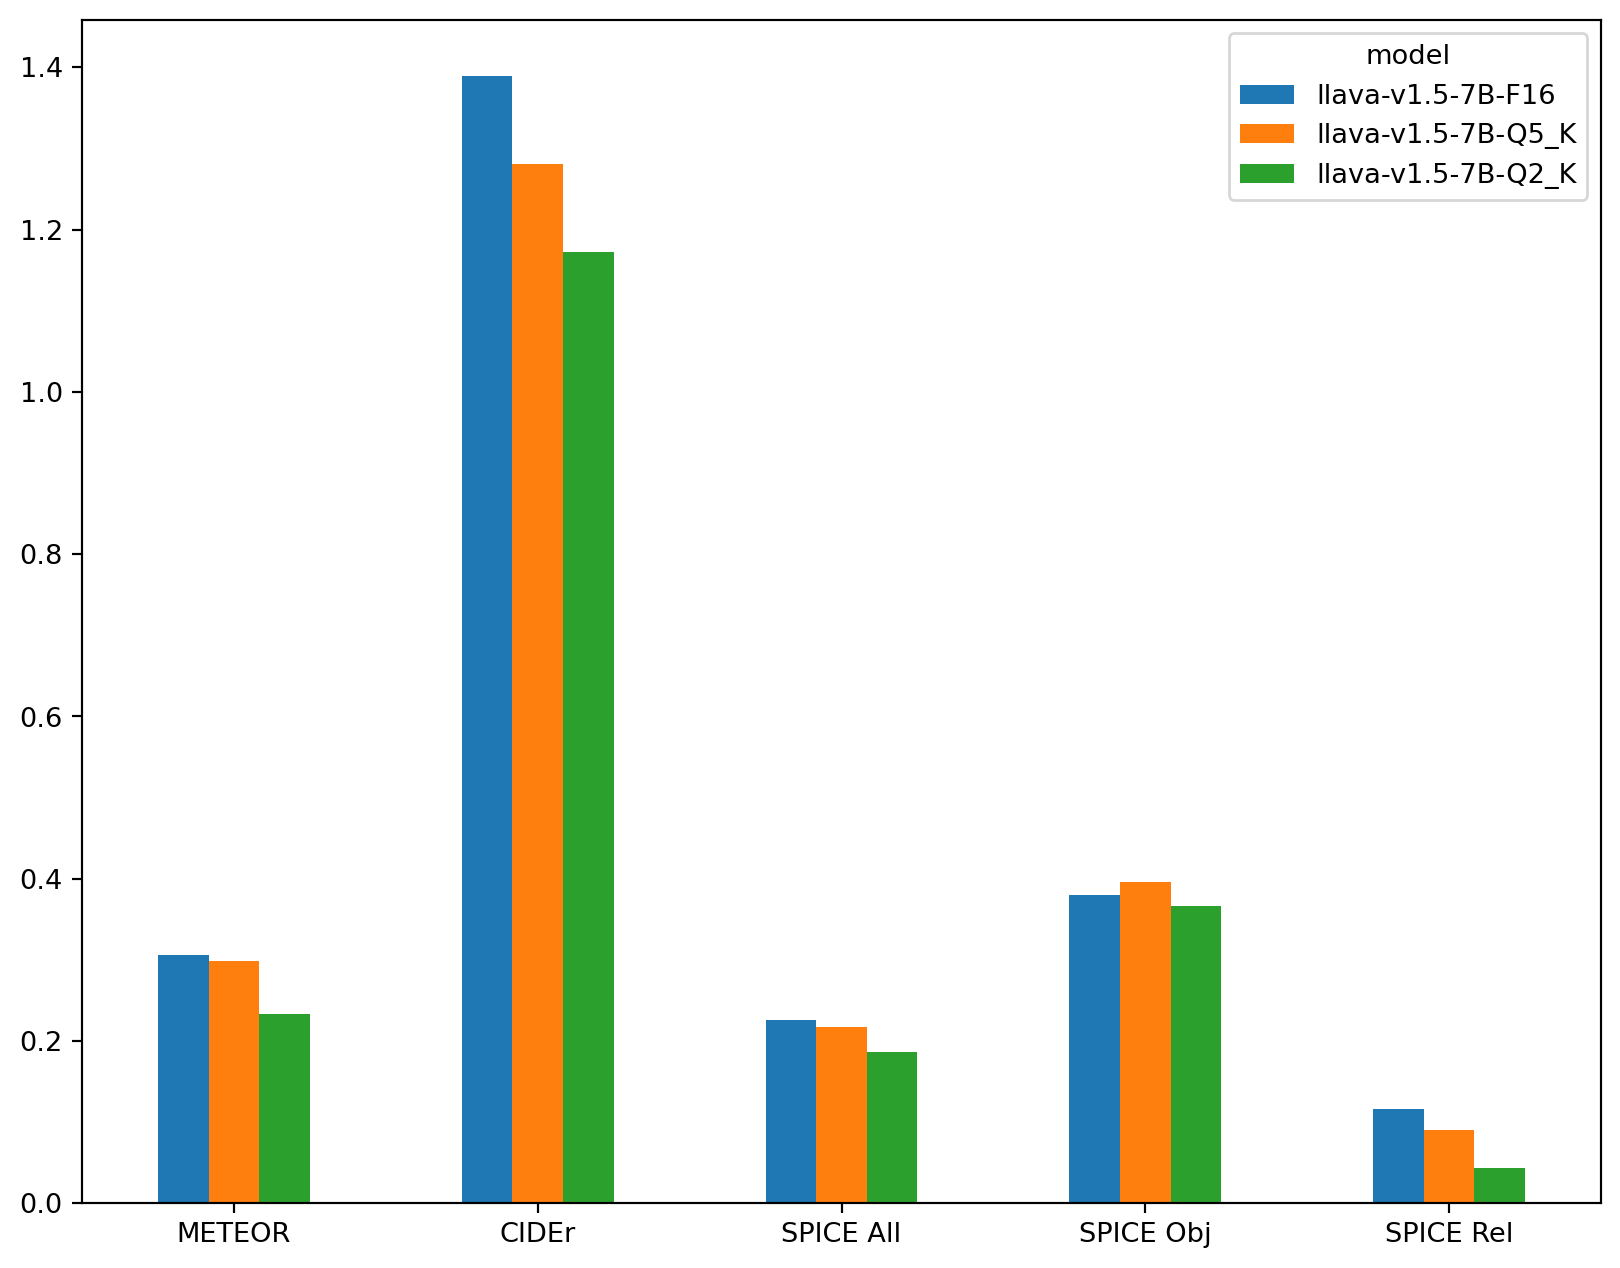

In [14]:
# TODO ipympl and %matplotlib notebook

ax = summary[['METEOR', 'CIDEr', 'SPICE All', 'SPICE Obj', 'SPICE Rel']].transpose().plot.bar()
plt.xticks(rotation=0)
ax